<a href="https://colab.research.google.com/github/adasegroup/ML2023_seminars/blob/master/seminar12/attention_seminar_part1/attention_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
if 'google.colab' in str(get_ipython()):
    import ssl
    import sys

    !wget https://raw.githubusercontent.com/adasegroup/ML2023_seminars/master/seminar12/model.pt -nc
    # sys.path.append('local_modules')

    ssl._create_default_https_context = ssl._create_unverified_context


File ‘model.pt’ already there; not retrieving.



# Attention mechanism from scratch

## Recap

* There is a standard solution to process sequential data- using a recurrent neural network. Neural networks use memory states to store processed elements and update memory when new items occur.

![RNN.png](https://raw.githubusercontent.com/zaaabik/msd2021/main/RNN.png)

* Before the attention mechanism appeared, if we want to solve a machine translation problem (or any seq-seq problem), we use RNN to compute some representation of a sequence using the encoder and then predict sequence by different RNN using obtained representations.  **Bottleneck problem!**

![machine-transaction.PNG](https://raw.githubusercontent.com/zaaabik/msd2021/main/machine-transaction.PNG)

**Soltution:** to reduce bottleneck problem, we could somehow connect predicted token not only with the previous token but with all elements from the encoder.



![attention-machine-translation](https://raw.githubusercontent.com/zaaabik/msd2021/main/attention.PNG)

### Key concepts of attention 

Attention is based on three core objects **query, key, value**.

Attention principles are very naturals and could be interpreted as:

1. Query - what you want to find (decoder)
2. Key - representation of data (encoder)
3. Value - the importance of the object in data (encoder)

The query is what you want to find in a date, key - represents data for query search, and value is information stored in an object. A natural example could be illustrated in the machine translation task. 

![language-model.png](https://raw.githubusercontent.com/zaaabik/msd2021/main/attention_sentence.png)

In this picture, queries from one language have bigger attention for words with the same meaning but in a different language.

## Lets go into details!



### Similarity coefficient
First of all, we need to compute the similarity coefficient between each question and key. 

\begin{align}
 cᵢⱼ = f(qᵢ, kⱼ) 
\end{align}
where $c$ is similairty coefficient between $i$-query with $j$ key.

Function $f$ could be an arbitrary function that returns the real number and describes two elements' similarities.

### Attention weights
For each $ q_i $, we compute similarity coefficient with whole keys and obtain vector from $ R^{n} $, where n - number of keys.
\begin{align}
 C_i  = [c_{i 1}, c_{i 2} ... c_{i n}]
\end{align}

One of the problems is that elements in $ C_i $ could be on a different scale. So, we want to map the sum into $(0, 1)$ and interpret elements as a probability. To do it, we use the softmax function:

\begin{align}
a_{ij} = \frac{\text{exp}(c_{i j})}{\sum_n \text{exp}(a_{in})}
\end{align}

\begin{align}
A_i  = softmax(C_i) = softmax([c_{i 1}, c_{i 2} ... c_{i n}])
\end{align}

### Attention matrix
Finally we get an attemtion matrix, where each row is softmaxed similarity coefficent of one query with all keys.

\begin{align}
A_i  = [
    A_1,\\
    A_2,\\
    ...\\
    A_{n - 1}\\
    A_n] 
\end{align}

### Attention output



The output of the attention block is a weighted sum of values.
\begin{align}
 O_k = \sum^n_{i = 1} a_{k i} v_i = A_k V
\end{align}

## Lets code!

In [3]:
!pip install torchtext==0.11.0
!pip install spacy==2.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.10.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.10.0 which is incompatible.
Looking in indexes: https://pypi.or

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

### Similarity coefficient
We should create a function that takes two vectors with the same shape and return a real value. The most straightforward measure is the dot product.

### Dot product attention
The core idea is to use a scaled dot product as a similarity coefficient.

\begin{align}
c  =  \frac{\langle \mathbf{q}, \mathbf{k} \rangle}{\sqrt{d}}
\end{align}
The function takes two vectors with the same dimension $q, k \in R^d$, and compute dot product and device by dimension size. Dividing helps reduce std difference for vectors with different size and make the function more general.

In [5]:
torch.manual_seed(0)

d = 256
x = torch.rand(d)
y = torch.rand(d)

def scalar_similarity_coefficient(x,y, d):
    ## TODO write scaled dot product
    return torch.dot(x,y) / np.sqrt(d)

similarity_score = scalar_similarity_coefficient(x,y, d)
assert(
    torch.allclose(similarity_score, 
                   torch.tensor(3.854549))
)

But there are many different functions we can use as a score function:


1.   Multilayer Perceptron Attention
\begin{align}
c = \mathbf{v}^T \text{tanh}(\mathbf{W}_k \mathbf{k} + \mathbf{W}_q \mathbf{q}).
\end{align}
2.   Neural network
\begin{align}
c = \text{NN}(q \mathbin\Vert k)
\end{align} where $q \mathbin\Vert k$ - concatenating the key and value in the feature dimension







To compute coefficient for multiple queries and keys efficient, we need to rewrite all in **vectorized form**.

We assume  $q \in R^{b, t, d}$ and $ k \in R^{b, k, d} $ where $b$ - batch size, $t$ and $k$ - number of queries and keys, $d$ - the shape of the data.

PyTorch framework has the function for multiplication elements in a batch manner. 

`torch.bnn(tensor1, tensor2)`
, where tensor1 is a $ (b \times n \times m) $ and tensor2 is a $ (b \times m \times p) $ . This function produce matrix multiplication for each object in a batch independent and output has shape $(b \times  n \; x \times p)$

In [6]:
## imagine that we have 10 queries and 8 keys and need to construce matrix of cofficent.

torch.manual_seed(0)
d = 64
t,k = 10, 8
batch_size = 3
query = torch.rand(10, d)
query = query.repeat(batch_size, 1, 1)

key = torch.rand(8, d)
key = key.repeat(batch_size, 1, 1)

def compute_coefficient_matrix(query, key, d):
    ## TODO write vectorized scaled dot product 
    return query @ key.transpose(-1,-2) / np.sqrt(d)

coefficient_matrix = compute_coefficient_matrix(query, key, d)

second_query = query[0, 2]
third_key = key[0, 3]

assert torch.allclose(coefficient_matrix[0, 2,3], scalar_similarity_coefficient(second_query, third_key, d))
assert torch.allclose(coefficient_matrix[0], coefficient_matrix[1])
assert torch.Size([batch_size, t,k]) == coefficient_matrix.shape

In [7]:
def slow_non_vector_compute_coefficient_matrix(query, key, d):
    b_s, q_l, _ = query.shape
    _, k_l, _ = key.shape
    out = torch.zeros(b_s, q_l, k_l)

    for b in range(b_s):
        for q in range(q_l):
            for k in range(k_l):
                current_query = query[b, q]
                current_key = key[b, k]
                out[b, q, k] = scalar_similarity_coefficient(current_query, current_key, d)
    return out


In [8]:
d = 64
t,k = 32, 10
batch_size = 128

query = torch.rand(batch_size, t, d)
key = torch.rand(batch_size, k, d)

In [9]:
%%time
slow_attention_results = slow_non_vector_compute_coefficient_matrix(query, key, d)

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.01 s


In [10]:
%%time
fast_attention_result = compute_coefficient_matrix(query, key, d)

CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 1.18 ms


**Using vectorization significant reduce attention computation time.**

In [11]:
assert torch.allclose(slow_attention_results, fast_attention_result)

After getting the coefficient matrix, we need to transform it into probabilities by applying the softmax function. Each row contains a coefficient between one query and all keys, which should be a probability distribution.

In [12]:
## imagine that we have 10 queries and 8 keys and need to construce matrix of cofficent.

torch.manual_seed(2)
d = 64
t,k = 10, 8
batch_size = 3
query = torch.rand(batch_size, 10, d)
key = torch.rand(batch_size, 8, d)

def compute_attention_matrix(query, key, d):
    coefficient_matrix = compute_coefficient_matrix(query, key, d)    
    ## TODO apply softmax
    attention_matrix = torch.softmax(coefficient_matrix, dim=-1)
    return attention_matrix

A = compute_attention_matrix(query, key, d)

assert np.allclose((A.sum(axis=-1) - 1).sum().numpy(), 0, atol=1e-6)
assert torch.all(A >= 0.0)

We could visualize the attention matrix where several rows correspond to the query and column number to the key, and the value shows the attention coefficient between them.

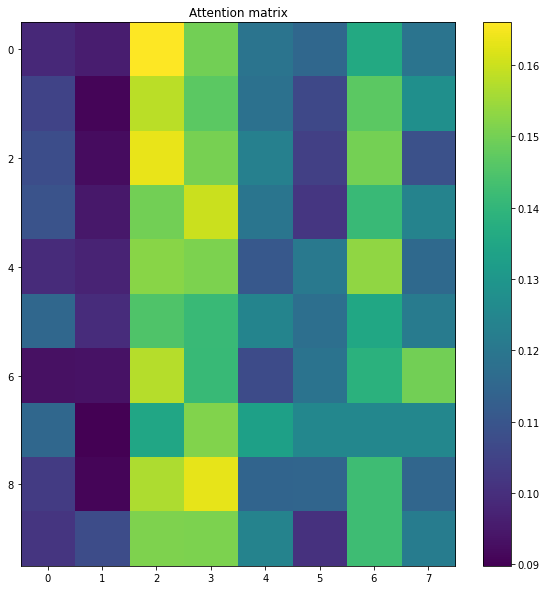

In [13]:
plt.figure(figsize=(10,10))
plt.title('Attention matrix')
plt.imshow(A[0])
plt.colorbar()

In this image attention, distribution should be almost uniform as we randomly initialize all elements, and the attention coefficient should be similar for all elements.

The last step is to use attention weights to compute the weighted sum of values. Sum each value with coefficient taken from the attention matrix.

\begin{align}
 O_k = \sum^n_{i = 1} a_{k i} v_i = A_k V
\end{align}
 where k - is a number of attention output

In [14]:
## imagine that we have 10 queries and 8 keys and need to construce matrix of cofficent.

torch.manual_seed(6)
d = 64
t,k = 10, 8
batch_size = 3
query = torch.rand(batch_size, t, d)
key = torch.rand(batch_size, k, d)
value = torch.rand(batch_size, k, d)

def attention(query, key, value, d):
    coefficient_matrix = compute_coefficient_matrix(query, key, d)    
    attention_matrix = torch.softmax(coefficient_matrix, dim=-1)
    out = attention_matrix @ value
    return attention_matrix, out 


A, out = attention(query, key, value, d)
assert out.shape == query.shape
assert torch.allclose(out.sum(), torch.tensor(973.154541015625))

### Attention layer
To help attention find interesting patterns in data, we use linear projections to create queries, keys and values. A model can train such a projection matrix and describe data in the best way to solve the problem.

\begin{align}
q = w_q x_q + b_q\\
k = w_k x_k \\
v = w_v x_v + b_v \\
\end{align}
where $ w_q, w_k, w_v \in R^{n,n}$

The following steps are the same with attention.

In [15]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, d):
        super().__init__()
        self.q_layer = torch.nn.Linear(d, d)
        self.k_layer = torch.nn.Linear(d, d, bias=False)
        self.v_layer = torch.nn.Linear(d, d)
        self.d = d

    def forward(self, query, key, value):
        self.q_proj = self.q_layer(query)
        self.k_proj = self.k_layer(key)
        self.v_proj = self.v_layer(value)        
        self.A, out = attention(self.q_proj, self.k_proj, self.v_proj, self.d)
        return out

d = 32
t,k = 10, 8
batch_size = 3
query = torch.rand(batch_size, t, d)
key = torch.rand(batch_size, k, d)
value = torch.rand(batch_size, k, d)


att_layer_out = AttentionLayer(32)(query, key, value)
assert att_layer_out.shape == query.shape
assert not torch.allclose(attention(query, key, value, d)[1], att_layer_out)

### Self-attention
Attention mechanism does not suggest any restriction for input data, and a large number of modern architectures use attention when all $x_q, x_k, x_v$ the same input data. In this case query, key, the value produced by the same source but after application of trainable projection matrix represent data from a different point of view.


\begin{align}
 x_q = x_k = x_v = x
\end{align}

\begin{align}
q = w_q x \\
k = w_k x \\
v = w_v x \\
\end{align}

In [16]:
d = 32
t = 10
batch_size = 3
x = torch.rand(batch_size, t, d)

att_layer_out = AttentionLayer(32)(x, x, x)

# Let's train models!

Let's consider toy examples to see how the attention mechanism work.
Our dataset is a sequence where each object represents a real number and flag. Our task is to find the sum of elements where the flag equals 1.

In [17]:
def generate_dataset(seq_len, sample_count, target_elements_per_seq=3):
    marker = torch.zeros(sample_count, seq_len)
    for i in range(sample_count):
        pos = np.random.permutation(np.arange(seq_len))[:target_elements_per_seq]        
        marker[i][pos] = 1.
    scaler = 10
    number = torch.rand(sample_count, seq_len) * scaler - scaler / 2
    y = (number * marker).sum(axis=1)
    x = torch.stack((number, marker), dim=-1)
    return x, y 


In [18]:
## generating data
## [
##    (x_1, flag_1), (x_2, flag_2) ... (x_n, flag_n)
## ]
x,y = generate_dataset(20, 10000)

In [19]:
## split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x,y )

In [20]:
## constructing train and validation
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, num_workers=2)

To construct keys and values, we use input data and then apply a projection matrix. We utilise one trainable query to filter our data (such construction equals a row of attention matrix). Then we compute attention between all keys and one query with attention layer and use the obtained coefficient to make a weighted sum of values.

In [21]:
class SummationAttentionModel(torch.nn.Module):
    def __init__(self, attention_layer, d):
        super().__init__()
        ## trainiable query
        self.syntetic_query = torch.nn.Parameter(torch.rand(1, 1, d))
        ## init layer for attention operation
        self.attention_layer = attention_layer
        ## we have one q in R^(d) -> output R^(d)
        ## linear layer map it in single output
        self.output_layer = torch.nn.Linear(d, 1)

    def forward(self, x):    
        ## make attention between syntetic_query and x
        out = self.attention_layer(self.syntetic_query, x, x)        
        ## out shape [n, 1, d] -> remove one dimension
        out = out[:, 0, :]        
        ##  [n, d] -> [n, 1] for solving regression task
        prediction = self.output_layer(out)[:, 0]
        return prediction

In [22]:
d = 2
## init model for our dataset with dimension size == 2
attention_layer = AttentionLayer(d)
model = SummationAttentionModel(attention_layer, d)

In [23]:
## model use MSE loss with adam optimizer with default parameters
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

In [24]:
model.train()
losses_by_epoch = []
## train model during 100 epochs
for epoch in tqdm(range(50)):
    epoch_loss = []
    for batch in train_dataloader:
        x,y = batch
        ## take input data and target
        pred = model(x)
        ## compute loss function and calculate gradients
        loss = criterion(y, pred)
        loss.backward()
        
        ## weights update
        optimizer.step()
        optimizer.zero_grad()
        
        ## store loss for future plots
        epoch_loss.append(loss.detach().item())            
    losses_by_epoch.append(np.mean(epoch_loss))
        

  0%|          | 0/50 [00:00<?, ?it/s]

Training loss during epoch should decrease

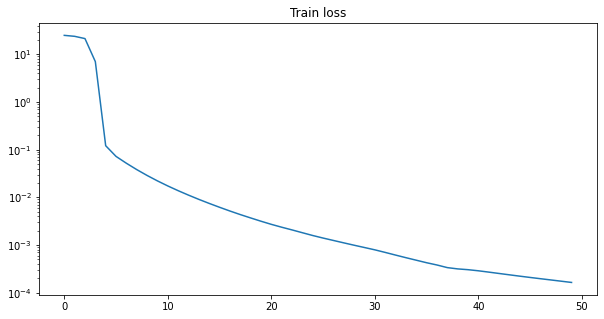

In [25]:
plt.figure(figsize=(10,5))
plt.title('Train loss')
plt.yscale('log')
plt.plot(losses_by_epoch);

Attention visualization

In [26]:
model.eval()
batch = next(iter(test_dataloader))
x,y = batch
pred = model(x)

## save attention matrix for validation examples
valid_attention = model.attention_layer.A.detach().numpy()[:, 0]

k = model.attention_layer.k_proj.detach().numpy()
v = model.attention_layer.v_proj.detach().numpy()
q = model.attention_layer.q_proj.detach().numpy()

Queries for target elements should be a closer query with respect to the zero point to make the scalar product bigger.

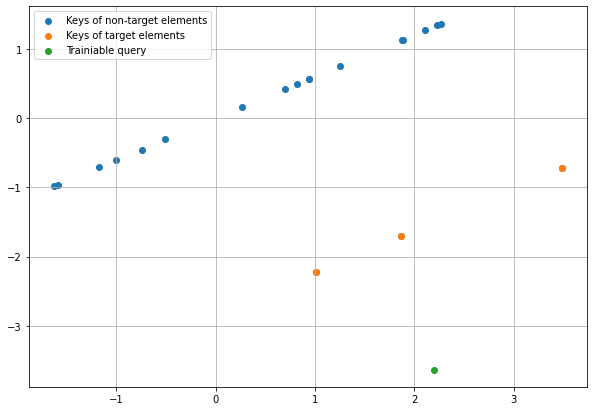

In [27]:
idx = 5
idx_of_target_examples = np.where(x[idx][:, 1] == 1)[0]

plt.figure(figsize=(10,7))
plt.scatter(k[idx, :, 0], k[idx, :, 1], label='Keys of non-target elements')
plt.scatter(k[idx, idx_of_target_examples, 0], k[idx, idx_of_target_examples, 1], label='Keys of target elements')

plt.scatter(q[0, :, 0], q[0, :, 1], label='Trainiable query')
plt.grid()
plt.legend()

The attention of query is close to zero for non-marked elements in a sequence, but considerable attention equals 1/3 because of softmax normalization.

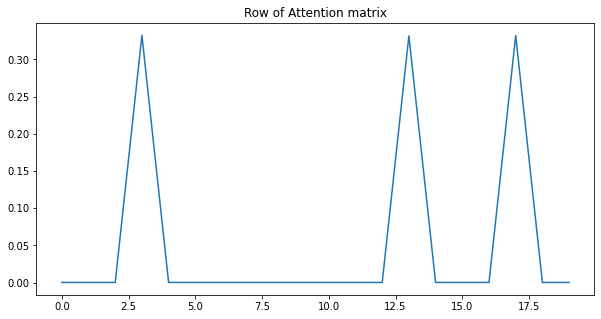

In [28]:
plt.figure(figsize=(10,5))
plt.title('Row of Attention matrix')
plt.plot(valid_attention[idx])

For different examples, the situation is the same. There are three peaks for each sequence that corresponds to the marked objects.

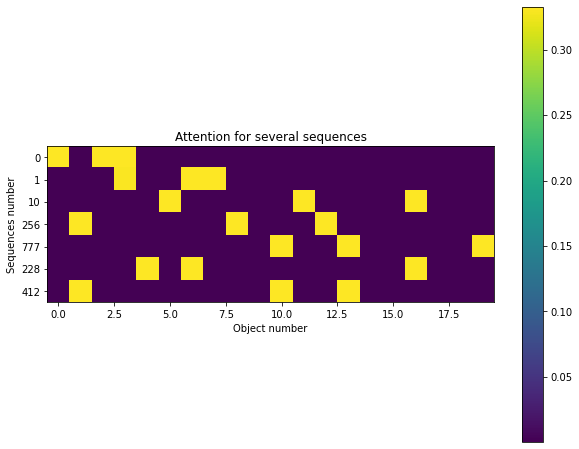

In [29]:
## attention of differernt examples
idxes = [0, 1,10 ,256, 777,228, 412]

plt.figure(figsize=(10,8))
plt.title('Attention for several sequences')
plt.yticks(range(len(idxes)), labels=idxes)
plt.ylabel('Sequences number')
plt.xlabel('Object number')
plt.imshow(valid_attention[idxes])
plt.colorbar()

All plots summarize our understanding of the attention mechanism in training queries and keys to pay more attention to relevant objects and reduce the influence of other objects.

In [30]:
## TODO: visualize values for marked and non marked objets

### Masked attention

There are many datasets where sequence length is different in real life, but we still need batch processing to make a model work fast and efficient. For this purpose, we use padding for a sequence.

![padded_sequence.png](https://raw.githubusercontent.com/zaaabik/msd2021/main/padded_sequence.png)

Our task is to create a model that pushes the model to ignore padding elements and make attention for them equal to zero.

![masked_non_masked_attention.png](https://raw.githubusercontent.com/zaaabik/msd2021/main/masked_non_masked_attention.png)

Your task is:


1.   Pad keys and values using 
`torch.nn.utils.rnn.pad_sequence(sequences, batch_first=False, padding_value=0.0)`. **Use parameter batch_first=True, to make output compatible with our attention function**
2.   Create a mask for keys and values, which help you make zeros in the attention matrix. To change the number in the attention matrix, you can use
`Tensor.masked_fill_(mask, value). This function takes Tensor and boolean masks with the same shape and then fills tensor elements with value parameters where the mask is True.



In [31]:
def masked_attention(query, key, value, mask, d):
    coefficient_matrix = compute_coefficient_matrix(query, key, d)    
    ## TODO: make an masked attention
    return attention_matrix, out

d = 64
t = 4
batch_size = 1
query = torch.rand(batch_size, t, d)
key = [
    torch.rand(4, d),
    torch.rand(1, d),
    torch.rand(6, d),
    torch.rand(3, d),
]
value = [ 
    torch.rand(4, d),
    torch.rand(1, d),
    torch.rand(6, d),
    torch.rand(3, d),
]

In [32]:
## TODO: print key and values, and find zeros at the end of short sequences
## TODO: plot attention matix, to see zeros coefficents

## Evaluate real model!

Based on [NLP example](https://teddykoker.com/2020/02/nlp-from-scratch-annotated-attention/)

Our task is to translate a sentence from German to English. We use the model where the encoder is the LSTM model, and the attention layer is applied as the decoder part. LSTM model generates hidden states and then uses the last hidden state of the predicted token as a query to find attention coefficients. After that model, make a weighted sum of hidden states of LSTM based attention coefficient and compute the next predicted token.

![attention-machine-translation](https://raw.githubusercontent.com/zaaabik/msd2021/main/attention.PNG)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm.notebook import tqdm
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [34]:
class Decoder(nn.Module):
    """
    Decode output from hidden state and context
    """
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, dropout):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.embed = nn.Embedding(output_dim, embed_dim)
        # stacking LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout)
        self.attention = Attention(hidden_dim) # we'll get to later
        self.wc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.ws = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, hidden, encoder_out):
        trg = trg.unsqueeze(0)
        embed = self.dropout(self.embed(trg))
        decoder_out, hidden = self.lstm(embed, hidden)
        
        # we'll go over how these are computed later
        atten, context = self.attention(decoder_out, encoder_out)
        
        # "We employ a simple concatenation layer to combine the 
        # information from both vectors:"
        atten_hidden = self.wc(torch.cat((decoder_out, context), dim=2)).tanh()

        # "The attentional vector ~h_t is then fed through the softmax layer
        # to produce the predictive distribution:"
        out = self.ws(atten_hidden.squeeze(0))
        # softmax will be included in loss function
        
        return out, hidden, atten

In [35]:
class Attention(nn.Module):
    """
    Compute alignment vector and context vector from hidden states
    """
    def __init__(self, hidden_dim, score_fn="general"):
        super(Attention, self).__init__()
        self.score_fn = score_fn
        if score_fn == "general":
            self.w = nn.Linear(hidden_dim, hidden_dim)
        if score_fn == "concat":
            self.w = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_dim))
            
    def score(self, decoder_out, encoder_outs):
        if self.score_fn == "dot":
            return torch.sum(decoder_out * encoder_outs, dim=2)
        if self.score_fn == "general":
            return torch.sum(decoder_out * self.w(encoder_outs), dim=2)
        if self.score_fn == "concat":
            decoder_outs = decoder_out.repeat(encoder_outs.shape[0], 1, 1)
            cat = torch.cat((decoder_outs, encoder_outs))
            return torch.sum(self.v * self.w(cat), dim=2)
            
    def forward(self, decoder_out, encoder_outs):
        score = self.score(decoder_out, encoder_outs)
        a = F.softmax(score, dim=0)
            
        # "Given the alignment vector as weights, the context vector 
        # c_t is computed as the weighted average over all the source 
        # hidden states:"
        context = torch.bmm(
            a.transpose(1, 0).unsqueeze(1),
            encoder_outs.transpose(1, 0)
        ).transpose(1, 0)
        return a, context

In [36]:
class Encoder(nn.Module):
    """
    Stacked LSTM encoder
    """
    def __init__(self, input_dim, embed_dim, hidden_dim, 
                 n_layers, dropout):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(input_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout) 
        
    def forward(self, src):
        embed = self.dropout(self.embed(src))
        out, hidden = self.lstm(embed)
        return self.dropout(out), hidden
    

class Model(nn.Module):
    """
    Sequence to Sequence model with attention
    """
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, src, trg, teacher_force_ratio = 0.5):
        outs = torch.zeros(
            trg.shape[0], trg.shape[1], self.decoder.output_dim
        ).to(src.device)
        encoder_out, hidden = self.encoder(src)
        
        x = trg[0]
        for t in range(1, trg.shape[0]):
            outs[t], hidden, _ = self.decoder(x, hidden, encoder_out)
            x = trg[t] if random.random() < teacher_force_ratio else outs[t].argmax(1)
            
        return outs

We choose a relatively small dataset with 30 thousand English-German sentence pairs.

In [37]:
import torchtext

In [38]:
## download dataset
!python -m spacy download en
!python -m spacy download de

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011738 sha256=b3ad93fe20e3710a47c2e1079f8c3dcad6e31ff0d88841e4703b97f38c162259
  Stored in directory: /tmp/pip-ephem-wheel-cache-fegrtksp/wheels/77/b4/c8/395804b9a2b6864aaff3623d7b709680acc3d04f47c8162ee6
Successfully built en_core_web_sm
  Attempting uninstall: en_core_web_sm
    Found existing installation: en-core-web-sm 3.4.1
    Uninstalling en-core-web-sm-3.4.1:
      Successfully uninstalled en-core-web-sm-3.4.1
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.8/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.8/dist-packages/spacy/data/en
You can now load the model via spacy

Common library torchtext includes a lot of powerful tools for text preprocessing and often appears in different NLP tasks. For our purpose, first of all, we initialize a ready tokenizer. Then put it in the special class Field ("analogue" of torch's Dataset) with other instructions for converting text to Tensor.

In [39]:
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import spacy

# tokenizers
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')
tokenize_de = lambda text: [tok.text for tok in spacy_de.tokenizer(text)]
tokenize_en = lambda text: [tok.text for tok in spacy_en.tokenizer(text)]

# fields
SRC = Field(tokenize=tokenize_de, init_token='<sos>',
            eos_token="<eos>", lower=True)
TRG = Field(tokenize=tokenize_de, init_token='<sos>',
            eos_token="<eos>", lower=True)

# data
train_data, valid_data, test_data = Multi30k.splits(('.de', '.en'), (SRC, TRG))
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:03<00:00, 388kB/s]


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 111kB/s] 


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 107kB/s] 


As we use a relatively small set of data, we can initialize a pretty simple model. The training time from scratch is ~30 minutes. 

In [40]:
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
embed_dim = 256
hidden_dim = 512
n_layers = 2
dropout = 0.2
batch_size = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def init_weights(model):
    for param in model.parameters():
        nn.init.uniform_(param.data, -0.1, 0.1)

train_loader, valid_loader, test_loader = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    device=device
)

encoder = Encoder(input_dim, embed_dim, hidden_dim, n_layers, dropout)

decoder = Decoder(output_dim, embed_dim, hidden_dim, n_layers, dropout)
model = Model(encoder, decoder).to(device)
model.apply(init_weights);

In [41]:
def step(model, data, criterion, train=False, optimizer=None):
    model.train() if train else model.eval()
    total_loss = 0
    for batch in tqdm(data, leave=False):
        if train: optimizer.zero_grad()
        pred = model(batch.src, batch.trg)
        loss = criterion(pred.view(-1, pred.size(2)), batch.trg.view(-1))
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data)

In [42]:
# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])
# num_epochs = 10



# best_loss = float('inf')
# train_loss, valid_loss = np.zeros((2, num_epochs))
# for e in range(num_epochs):
#     train_loss[e] = step(model, train_loader, criterion, train=True, optimizer=optimizer)
#     valid_loss[e] = step(model, valid_loader, criterion)
#     #print(f"epoch: {e} train_loss: {train_loss[e]:.2f} valid_loss: {valid_loss[e]:.2f}")
#     if valid_loss[e] < best_loss:
#         torch.save(model.state_dict(), 'model.pt')
#         best_loss = valid_loss[e]

# plt.figure(figsize=(5, 3), dpi=300)
# plt.plot(train_loss[:10], label="Train")
# plt.plot(valid_loss[:10], label="Valid.")
# plt.legend(); plt.ylabel("Cross-Entropy Loss"); plt.xlabel("Epoch")
# plt.show()

Of course, we can't wait this time, so we upload pre-trained weights. The interested listener can try to train the model by himself (uncomment above):) 

In [43]:
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])
model.load_state_dict(torch.load("model.pt", map_location='cpu'))
test_loss = step(model, test_loader, criterion)
print(f"Test loss: {test_loss:.2f}")
print(f"Test perplexity: {np.exp(test_loss):.2f}")

  0%|          | 0/8 [00:00<?, ?it/s]

Test loss: 2.52
Test perplexity: 12.39


**Let's translate!** 

In [44]:
@torch.no_grad()
def translate(sentence, model, device, max_len=50):
    model.eval()
    src = SRC.process([sentence]).to(device)
    trg = torch.ones(1, dtype=torch.int64).to(device) * TRG.vocab.stoi[TRG.init_token]
    trgs, attention = [], []
    encoder_out, hidden = model.encoder(src)
    
    for t in range(max_len):
        trg, hidden, atten = model.decoder(trg, hidden, encoder_out)
        trg = trg.argmax(1)
        trgs.append(trg)
        attention.append(atten.T)
        if trg == TRG.vocab.stoi[TRG.eos_token]: break

    trg = [TRG.vocab.itos[i] for i in trgs]
    src = [SRC.vocab.itos[i] for i in src]
    attention = torch.cat(attention).cpu().numpy()[:-1, 1:]
    return src, trg, attention

In [45]:
example = 6
src, trg = test_data[example].src, test_data[example].trg
print(f"Source: {' '.join(src)}")
print(f"Target: {' '.join(trg)}")

Source: eine gruppe von menschen steht vor einem iglu .
Target: a group of people standing in front of an igloo .


In [46]:
src, pred, attention = translate(src, model, device)
print(f"Prediction: {' '.join(pred[:-1])}")

Prediction: a group of people standing in front of an igloo .


![igloo.jpg](https://raw.githubusercontent.com/zaaabik/msd2021/main/igloo.jpg)

<ipython-input-47-fc911c45aa28>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src, rotation=60)
<ipython-input-47-fc911c45aa28>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + trg)


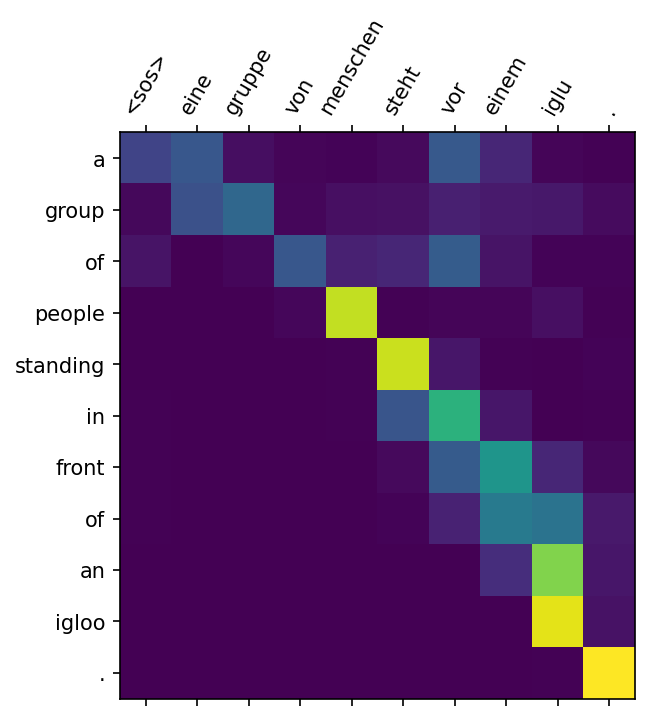

In [47]:
def plot_attention(src, trg, attention):
    fig = plt.figure(figsize=(5, 5), dpi=150)
    ax = fig.add_subplot(111)
    ax.matshow(attention)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + src, rotation=60)
    ax.set_yticklabels([''] + trg) 
    
plot_attention(src, pred, attention)

In [48]:
src = 'Mann im schwarzen Anzug geht zur Bushaltestelle'.lower().split(' ')

In [49]:
src, pred, attention = translate(src, model, device)
print(f"Prediction: {' '.join(pred[:-1])}")
print(src)

Prediction: man in a black suit walks past bus bus .
['<sos>', 'mann', 'im', 'schwarzen', 'anzug', 'geht', 'zur', 'bushaltestelle', '<eos>']


<ipython-input-47-fc911c45aa28>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src, rotation=60)
<ipython-input-47-fc911c45aa28>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + trg)


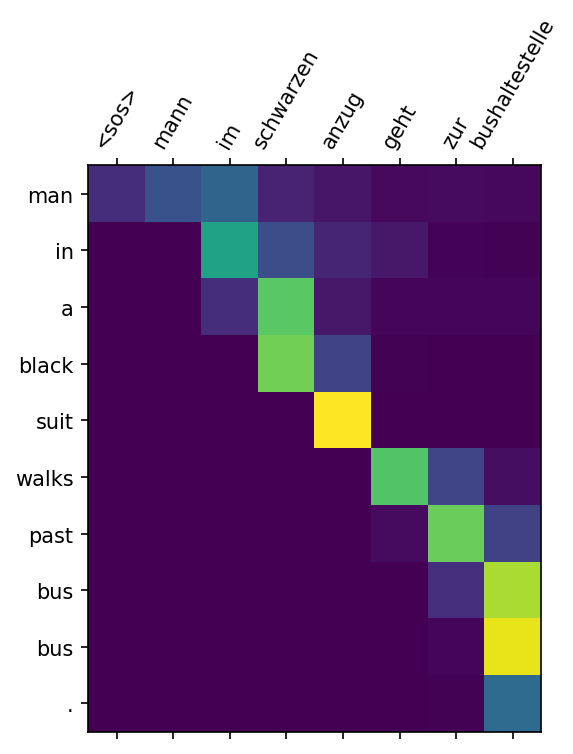

In [50]:
plot_attention(src, pred, attention)

![men_in_black_3_still.jpg](https://raw.githubusercontent.com/zaaabik/msd2021/main/men_in_black_3_still.jpg)

In [51]:
### ##TODO: Find arbitrary German sentence -> translate -> plot attention matrix

The authors use both attention and multi-head attention to make the model more robust. Such technical make model able to have different attention matrices in the same layer and look into different objects.

## Summary

*   Query, key helps the model find a relevant object in a sequence + interpretable.
*   Computing attention matrix in a vectorize form significant improve the speed.
*   For batch processing with sequences with different lengths, masked attention should be used.
*   Attention mechanism help model directly use objects on a sequence and improve quality of RNN models.
*   There are several functions used as the score function.